1. Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.
2. *Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import random

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

In [2]:
#Реализуем генерацию  𝑁 бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.
np.random.seed(42)

def get_bootstrap(data, labels, N): # N-сколько на выходе мы хотим получить подвыборок
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = [] #список в который запишем наши бустропированые подвыборки
    for i in range(N):# циклом проходимся по колличеству будующих деревьев в композиции
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)#генерируем индексы в том колличестве сколько у нас всего обьектов, т.е. в нашем случае 1000 обьектов
        b_data = data[sample_index] # признаки для обучения
        b_labels = labels[sample_index] #целевые значения для обучения
        
        bootstrap.append((b_data, b_labels))#добовление бустропированной выборки
        
    return bootstrap #возвращаем кортеж из признаков и целевых значений

In [3]:
#создаем функцию для получение признаков для каждого уникального вопроса
def get_subsample(len_sample): # подаем кол-во признаков
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))# т.к задача на классификацию, 
    #то берем корень квадратный из общего колличества признаков, 
    #на регрессию общее кол-во ппризнаков деленное на 3
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)#replace=False без повторения,
    #что бы небыло дублирований в признаках для обучения

    return subsample

In [4]:
# Реализуем класс узла, в нем лежит сам вопрос для выборки

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get) #берем самый популярный класс, делаем "голосование",
        #если бы была регрессия брали бы среднее по выборке
        return prediction   

In [6]:
# Расчет критерия Джини(информативности)

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels) #вероятность появления кождого класса в выборке
        impurity -= p ** 2 #возводим вероятность в квадрат и вычетаем из 1
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
#на них мы будем выберать самый лучьший вопрос    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
#функция для формирования случайного леса.
def random_forest(data, labels, n_trees):#n_trees-кол-во деревьев 
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    #print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    #print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

**1. Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.**

In [16]:
# Загрузим датасет IRIS
iris = load_iris()
X = iris.data
y = iris.target

print(X.shape)

(150, 4)


In [17]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
def metrics_random_forest(train_data, train_labels, n_trees):
    my_forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    return test_accuracy

In [19]:
print(metrics_random_forest(train_data, train_labels, 2))

95.55555555555556


In [20]:
def pca(X, n_components):
    # Центрирование данных
    X = X - np.mean(X, axis=0)
    
    # Вычисление матрицы ковариации данных
    cov_matrix = np.cov(X.T)
    
    # Вычисление сингулярного разложения матрицы ковариации данных
    U, S, V = np.linalg.svd(cov_matrix)
    
    # Сортировка сингулярных значений в порядке убывания и соответствующих им сингулярных векторов
    idx = np.argsort(-S)
    U = U[:, idx]
    S = S[idx]
    
    # Выбор наиболее значимых сингулярных векторов
    U_reduced = U[:, :n_components]
    
    # Умножение матрицы данных на выбранные сингулярные векторы
    X_reduced = np.dot(X, U_reduced)
    
    return X_reduced

In [21]:
X_reduced = pca(X, 2)

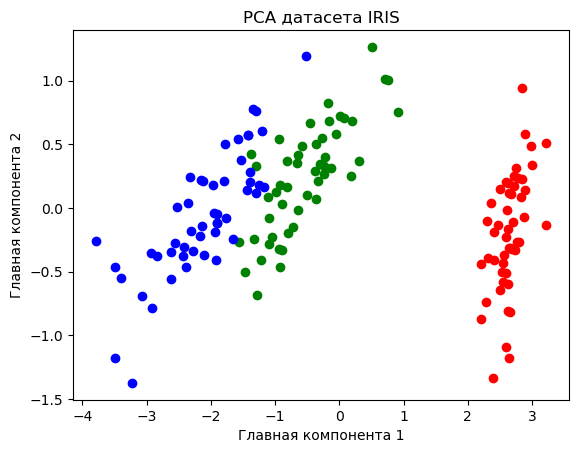

In [22]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_reduced[y==i, 0], X_reduced[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [23]:
# Уменьшим размерность с помощью PCA, написанной выше.
X_reduced = pca(X, 2)

In [24]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

In [25]:
print(metrics_random_forest(train_data, train_labels, 2))

84.44444444444444


После уменьшения размерности, точность снизилась. Это связано с потерей части информации, что в нашем случаи и привело к ухудшению показателей.